## Load Data From Kaggle

In [1]:
import os
import time
import kagglehub
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from optuna.integration import XGBoostPruningCallback
from xgboost import XGBClassifier
from util import preprocess_data, ThresholdClassifier

path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")
datasets = []

dataset_names = [
    "Nigerian_Fraud.csv",
    "Ling.csv",
    "Nazario.csv",
    "SpamAssasin.csv",
    "CEAS_08.csv"
 ]
for file in dataset_names:
    csv_path = os.path.join(path, file)
    subset_data = pd.read_csv(csv_path)
    datasets.append(subset_data)

data = pd.concat(datasets)
print(f"\nNumber of samples: {data.shape[0]}")


y = data['label'] 
X = preprocess_data(data.drop(columns=['label']))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



c:\Users\James\Documents\phishguard\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Number of samples: 52719


## Find Best Model Parameters

In [ ]:
GPU = True
MAX_FEATURES = 25000

def objective(trial):
    start_time = time.time()
    # XGBoost Params
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
    max_depth = trial.suggest_int('max_depth', 4, 20, log=True)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.1, .9)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9)

    # Vectorizer Params
    stop_words_choice = trial.suggest_categorical('stop_words_setting', ['english', 'none'])
    stop_words = 'english' if stop_words_choice == 'english' else None

    subject_min_df = trial.suggest_int('subject_min_df', 3, 30)
    body_min_df = trial.suggest_int('body_min_df', 3, 30)
    ngram_min_df = trial.suggest_int('ngram_min_df', 3, 30)
    max_df = trial.suggest_float('max_df_float', 0.7, 1.0)

    # Feature calculation logic
    model_features = trial.suggest_int('model_features', 5000, MAX_FEATURES, log=True)
    sub_word_feature_share = trial.suggest_int('sub_word_feature_share', 1, 100)
    body_word_feature_share = trial.suggest_int('body_word_feature_share', 1, 100)
    ngram_feature_share = trial.suggest_int('ngram_feature_share', 1, 100)
    total_shares =  sub_word_feature_share + body_word_feature_share + ngram_feature_share

    sub_word_weight = sub_word_feature_share / total_shares
    body_word_weight = body_word_feature_share / total_shares
    ngram_weight = ngram_feature_share / total_shares

    sub_word_features = int(sub_word_weight * model_features)
    body_word_features = int(body_word_weight * model_features)
    ngram_features = int(ngram_weight * model_features)

    trial.set_user_attr('subject_word_feature_weight', sub_word_weight)
    trial.set_user_attr('body_word_feature_weight', body_word_weight)
    trial.set_user_attr('ngram_feature_weight', ngram_weight)

    trial.set_user_attr('subject_word_features',sub_word_features)
    trial.set_user_attr('body_word_features', body_word_features)
    trial.set_user_attr('ngram_features', ngram_features)

    ngram_size = trial.suggest_int('ngram_size', 2, 5)


    # Cross-Validation
    n_folds = 3
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_aucs = []

    for i, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):

        X_fold_train, X_fold_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_fold_train, y_fold_valid = y_train.iloc[train_index], y_train.iloc[valid_index]


        ngram_vec = TfidfVectorizer(
            lowercase=True,
            analyzer='word',
            ngram_range=(2,ngram_size),
            min_df=ngram_min_df,
            max_features=ngram_features
        )

        sub_word_vec = TfidfVectorizer(
            lowercase=True,
            analyzer='word',
            min_df=subject_min_df,
            max_features=sub_word_features
        )

        body_word_vec = TfidfVectorizer(
            lowercase=True,
            analyzer='word',
            min_df=body_min_df,
            max_df=max_df,
            stop_words=stop_words,
            max_features=body_word_features
        )


        # Define Vectorizer
        vectorizer = ColumnTransformer([
            ('sub_char_vectorizer', TfidfVectorizer(lowercase=False, analyzer='char'),'subject'),
            ('sub_word_vectorizer', sub_word_vec, 'subject'),
            ('body_vectorizer', body_word_vec, 'body'),
            ('ngram_vectorizer', ngram_vec, 'subject_body')
            ],
            remainder="passthrough"
        )

        # Transform Data
        vectorizer.fit(X_fold_train)
        X_fold_train_vec = vectorizer.transform(X_fold_train)
        X_fold_valid_vec = vectorizer.transform(X_fold_valid)

        # Pruning Callback: (ONLY on the first fold)
        callbacks = [XGBoostPruningCallback(trial, "validation_0-auc")] if i == 0 else None

        # Initialize Model
        model = XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            n_jobs=-1,
            tree_method='hist',
            device='cuda' if GPU else 'cpu',
            objective='binary:logistic',
            eval_metric='auc',
            early_stopping_rounds=30,
            callbacks=callbacks
        )

        try:
            model.fit(
                X_fold_train_vec,
                y_fold_train,
                eval_set=[(X_fold_valid_vec, y_fold_valid)],
                verbose=False
            )
        except Exception as e:
            if "out of memory" in str(e):
                print(f"Trial {trial.number} Fold {i} failed due to GPU OOM. Skipping...")
                return 0.998
            else:
                raise e

        # Calculate Fold AUC
        preds_proba = model.predict_proba(X_fold_valid_vec)[:, 1]
        fold_auc = roc_auc_score(y_fold_valid, preds_proba)
        fold_aucs.append(fold_auc)


    # Average the AUC across all 5 folds
    mean_auc = np.mean(fold_aucs)
    elapsed = time.time() - start_time
    print(f"Trial {trial.number} done in {elapsed:.2f}s | Mean AUC: {mean_auc:.6f}")

    return mean_auc

# Sampler and pruner
sampler = optuna.samplers.TPESampler(multivariate=True, seed=42)
pruner = optuna.pruners.HyperbandPruner(
    min_resource=100,
    max_resource=1000,
    reduction_factor=3

)
# Use SQLite storage to persist results
study_name = "phishguard_optimization"
storage_name = f"sqlite:///{study_name}.db"

study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    direction='maximize',
    pruner=pruner,
    sampler=sampler
)

c:\Users\James\Documents\phishguard\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-13 20:58:27,594] Using an existing study with name 'phishguard_final_2' instead of creating a new one.


In [ ]:
study.optimize(objective, n_jobs=1, n_trials=50)

[W 2025-12-13 20:58:27,934] The parameter `model_features` in Trial#49 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.
[I 2025-12-13 20:59:56,038] Trial 49 pruned. Trial was pruned at iteration 100.


## Visualize Tuning Results

In [4]:
# -- Visualize Parameter Tuning results
best_params = study.best_params
print(f"Best value (AUC): {study.best_value}")
print(f"Best params: {best_params}")

importances = optuna.importance.get_param_importances(study)
print("\nParameter Importances:")
for param, score in importances.items():
    print(f"{param}: {score:.4f} ({score*100:.2f}%)")
    
df = study.trials_dataframe()
df = df[df.state == "COMPLETE"].copy()
important_features = [c for c in df.columns if c.startswith('params_')]
optuna.visualization.plot_slice(study)

Best value (AUC): 0.9995814112645781
Best params: {'n_estimators': 621, 'max_depth': 14, 'learning_rate': 0.045870680935945256, 'subsample': 0.5770650091021022, 'colsample_bytree': 0.10661978582483134, 'stop_words_setting': 'none', 'subject_min_df': 15, 'body_min_df': 29, 'ngram_min_df': 30, 'max_df_float': 0.8748709373312227, 'model_features': 5137, 'sub_word_feature_share': 11, 'body_word_feature_share': 81, 'ngram_feature_share': 90, 'ngram_size': 4}

Parameter Importances:
ngram_feature_share: 0.6051 (60.51%)
max_depth: 0.1072 (10.72%)
body_word_feature_share: 0.0732 (7.32%)
ngram_min_df: 0.0613 (6.13%)
max_df_float: 0.0246 (2.46%)
colsample_bytree: 0.0229 (2.29%)
learning_rate: 0.0214 (2.14%)
body_min_df: 0.0200 (2.00%)
ngram_size: 0.0173 (1.73%)
stop_words_setting: 0.0167 (1.67%)
n_estimators: 0.0117 (1.17%)
subsample: 0.0108 (1.08%)
subject_min_df: 0.0045 (0.45%)
sub_word_feature_share: 0.0034 (0.34%)


## Build Final Model

In [5]:
# -- Rebuild best model --
if best_params['stop_words_setting'] == 'english':
    final_stop_words = 'english'
else:
    final_stop_words = None

attributes = study.best_trial.user_attrs

ngram_features = int(attributes['ngram_feature_weight'] * best_params['model_features'])
sub_word_features = int(attributes['subject_word_feature_weight'] * best_params['model_features'])
body_word_features = int(attributes['body_word_feature_weight'] * best_params['model_features'])

ngram_vec = TfidfVectorizer(
            lowercase=True,
            analyzer='word',
            ngram_range=(2, best_params['ngram_size']),
            min_df=best_params['ngram_min_df'],
            max_features=ngram_features
        )

sub_word_vec = TfidfVectorizer(
    lowercase=True,
    analyzer='word',
    min_df=best_params['subject_min_df'],
    max_features=sub_word_features
)

body_word_vec = TfidfVectorizer(
    lowercase=True,
    analyzer='word',
    min_df=best_params['body_min_df'],
    max_df=best_params['max_df_float'],
    stop_words=final_stop_words,
    max_features=body_word_features
)


# Define Vectorizer
final_vectorizer = ColumnTransformer([
    ('sub_char_vectorizer', TfidfVectorizer(lowercase=False, analyzer='char'),'subject'),
    ('sub_word_vectorizer', sub_word_vec, 'subject'),
    ('body_vectorizer', body_word_vec, 'body'),
    ('ngram_vectorizer', ngram_vec, 'subject_body')
    ],
    remainder="passthrough"
)

# Initialize Model
final_model = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    n_jobs=-1,
    tree_method='hist',
    device='cuda' if GPU else 'cpu',
    objective='binary:logistic',
    eval_metric='auc',
)

full_pipeline = Pipeline([
    ('preprocessor', final_vectorizer),
    ('classifier', final_model)
])

## Train Final Model and Optimize Threshold

In [6]:

print("Generating cross-validated probabilities for threshold tuning...")
y_train_proba = cross_val_predict(
    full_pipeline,
    X_train,
    y_train,
    cv=3,
    method='predict_proba',
)[:, 1]

# Find threshold that maximizes F1
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_proba)
numerator = 2 * (precisions * recalls)
denominator = precisions + recalls
f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
best_idx = np.argmax(f1_scores[:-1])   # ignore last element which corresponds to no threshold
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Optimal Threshold (OOF CV): {best_threshold:.4f}  -- Best F1 (OOF CV): {best_f1:.4f}")
print(f"Calibrating probabilities (n_samples={len(X_train)})...")

# Add calibration
calibrated = CalibratedClassifierCV(
    estimator=full_pipeline,
    method='isotonic',
    cv=3,
)
calibrated.fit(X_train, y_train)

# Create and save final "deployment" classifier object
deployment_filename = 'phishguard_deployment.joblib'
deployment_model = ThresholdClassifier(estimator=calibrated, threshold=best_threshold)
print(f"Saving wrapped calibrated model (with threshold={best_threshold:.4f}) to '{deployment_filename}'...")
joblib.dump(deployment_model, deployment_filename)
print("Model saved.")


Generating cross-validated probabilities for threshold tuning...


c:\Users\James\Documents\phishguard\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning:

[21:00:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.




Optimal Threshold (OOF CV): 0.4828  -- Best F1 (OOF CV): 0.9928
Calibrating probabilities (n_samples=42175)...
Saving wrapped calibrated model (with threshold=0.4828) to 'phishguard_deployment.joblib'...
Model saved.


## Visualize Results On Training Data

Evaluating on Test Set...

Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.993     0.990     0.991      4678
           1      0.992     0.994     0.993      5866

    accuracy                          0.992     10544
   macro avg      0.992     0.992     0.992     10544
weighted avg      0.992     0.992     0.992     10544



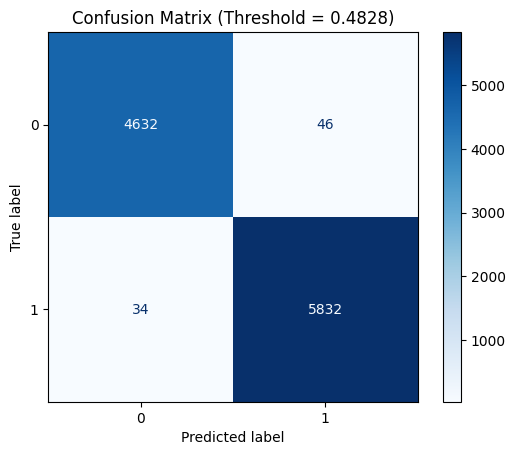

In [7]:
# Predict on test set using the optimal threshold
print("Evaluating on Test Set...")
y_test_pred = deployment_model.predict(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, digits=3))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (Threshold = {best_threshold:.4f})")
plt.show()